In [1]:
import bento as bt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

#to read in tiff image
import tifffile as tiff #to load TIFF image into a np array

## Prepare AnnData with molecule-level spatial data

`bento.io.prepare(molecules, cell_seg, x='x', y='y', gene='gene', other_seg={})`

* molecules: Dataframe --> tile_40_detected_pixel_coords.csv
* cell_seg: labeled_cellbound2-cellbound3_z3_tile40.tif
* x: columns of the matrix
* y: rows of the matrix
* gene='gene'
* other_seg={DAPI} labeled_DAPI_z3_tile40.tif

In [2]:
import rasterio

In [3]:
molecules = pd.read_csv('/media/gambino/students_workdir/nynke/colonCancer_tile40/tile_40_detected_pixel_coords.csv')
cell_seg = tiff.imread('/media/gambino/students_workdir/nynke/colonCancer_tile40/labeled_images/labeled_cellbound2-cellbound3_z3_tile40.tif')
DAPI= tiff.imread('/media/gambino/students_workdir/nynke/colonCancer_tile40/labeled_images/labeled_DAPI_z3_tile40.tif')

In [4]:
print("type(molecules): " + str(type(molecules)))
print('type(cell_seg): ' + str(type(cell_seg)))
print('cell_seg.dtype: ' + str(cell_seg.dtype))
print('type(DAPI): ' + str(type(DAPI)))
print('DAPI.dtype: ' + str(DAPI.dtype))

#rasterio_array = cell_seg.astype(rasterio.uint16)
#print(rasterio_array.dtype)

type(molecules): <class 'pandas.core.frame.DataFrame'>
type(cell_seg): <class 'numpy.ndarray'>
cell_seg.dtype: uint16
type(DAPI): <class 'numpy.ndarray'>
DAPI.dtype: uint16


In [23]:
adata = bt.io.prepare(molecules, cell_seg, x='x', y='y', gene='gene', other_seg={'nucleus': DAPI})

  0%|          | 0/6 [00:00<?, ?it/s]

## Rundown Bento Tutorial

In [6]:
#load data.
adata2 = bt.ds.sample_data() 

In [7]:
print(adata[0:10,])
print(adata2[0:10,])

View of AnnData object with n_obs × n_vars = 10 × 550
    obs: 'cell_shape', 'nucleus_shape'
    uns: 'points'
View of AnnData object with n_obs × n_vars = 10 × 135
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'point_sets', 'points'
    layers: 'spliced', 'unspliced'


In [24]:
print(adata.obs.columns)
print(adata2.obs.columns)

#our dataset doesn't have a batch, so add it 
adata.obs['batch']= 1
print(adata.obs.columns)

Index(['cell_shape', 'nucleus_shape'], dtype='object')
Index(['cell_shape', 'nucleus_shape', 'batch'], dtype='object')
Index(['cell_shape', 'nucleus_shape', 'batch'], dtype='object')


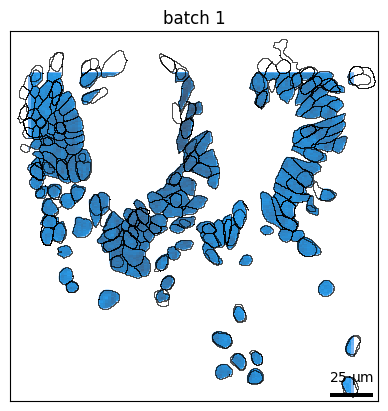

In [9]:
bt.pl.density(adata) #plot RNA distributions and cell/nuclear segmentation masks

In [25]:
# Filter out cells without a nucleus
adata = adata[adata.obs["nucleus_shape"] != None]
bt.sync(adata)
adata

AnnData object with n_obs × n_vars = 166 × 550
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points', 'point_sets'

In [26]:
# Keep genes where at least 10 molecules are detected in at least one cell
gene_filter = (adata.X >= 10).sum(axis=0) > 0
adata = adata[:, gene_filter]
bt.sync(adata)
adata

AnnData object with n_obs × n_vars = 166 × 439
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points', 'point_sets'

### Spatial summary statistics
Quick summary of cell and nuclear properties, including area, shape (i.e. aspect ratio) and RNA density

In [12]:
bt.tl.obs_stats(adata)

  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_density, cell_aspect_ratio, cell_area


  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + nucleus_area, nucleus_aspect_ratio, nucleus_density


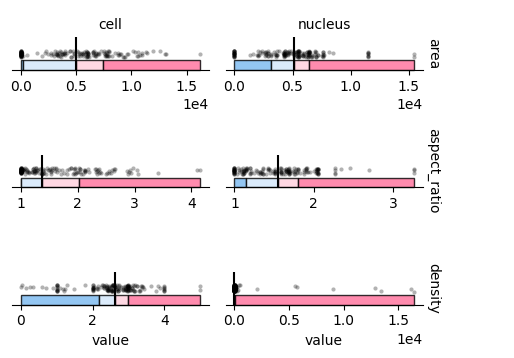

In [13]:
bt.pl.obs_stats(adata)

### Predict subcellular domains
RNAflux quantifies spatial composition gradients to capture subcellular changes in expression, represented as a `[pixel x gene]` embedding.

In [14]:
res = 0.1
bt.tl.flux(adata, radius=50, res=res) #automatically performs PCA and saves first 10 principal components in `uns['flux_embed']`
#can visualize the first 3 PCs by mapping them to RGB values (red = PC1, green = PC2, and bleu = PC3) for each pixel

  0%|          | 0/3 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_raster
    uns:
        + cell_raster


  0%|          | 0/166 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + cell_raster
    uns:
        + flux_embed, flux, flux_color, cell_raster, flux_variance_ratio, flux_genes


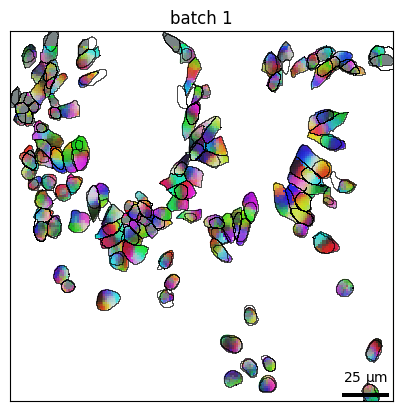

In [15]:
bt.pl.flux(adata, res=res)

### Fluxmaps 
Cluster pixels in reduced PCA space by RNAflux embeddings . Use elbow heuristic for optimal number of clusters

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

AnnData object modified:
    obs:
        + fluxmap5_shape, fluxmap1_shape, fluxmap2_shape, fluxmap3_shape, fluxmap4_shape


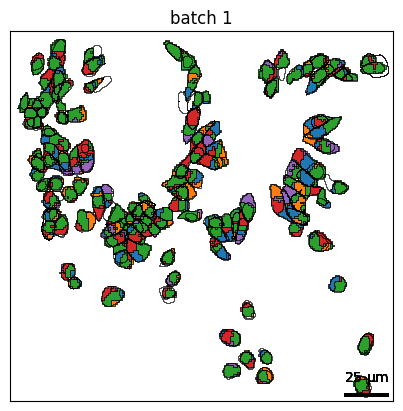

In [16]:
bt.tl.fluxmap(adata, n_clusters=5, res=res)
bt.pl.fluxmap(adata)

### RNAforest: predict&annotate subcellular localization patterns
1 sample: 1 gene 1 cell

Can predict:
* cell edge
* cytoplasmic
* nuclear
* nuclear edge
* none of the above 

In [17]:
bt.tl.fe_fazal2019(adata)

ValueError: setting an array element with a sequence.

In [29]:
bt.tl.lp(adata)

Crunching shape features...
Crunching point features...


ValueError: max() arg is an empty sequence

In [19]:
adata

AnnData object with n_obs × n_vars = 166 × 439
    obs: 'cell_shape', 'nucleus_shape', 'batch', 'cell_area', 'cell_aspect_ratio', 'cell_density', 'nucleus_area', 'nucleus_aspect_ratio', 'nucleus_density', 'cell_raster', 'fluxmap1_shape', 'fluxmap2_shape', 'fluxmap3_shape', 'fluxmap4_shape', 'fluxmap5_shape', 'cell_span', 'cell_minx', 'cell_miny', 'cell_maxx', 'cell_maxy', 'cell_radius'
    uns: 'points', 'point_sets', 'cell_raster', 'flux', 'flux_genes', 'flux_embed', 'flux_variance_ratio', 'flux_color'

In [28]:
adata

AnnData object with n_obs × n_vars = 166 × 439
    obs: 'cell_shape', 'nucleus_shape', 'batch', 'cell_area', 'cell_raster', 'cell_span', 'cell_minx', 'cell_miny', 'cell_maxx', 'cell_maxy', 'cell_radius'
    uns: 'points', 'point_sets', 'cell_raster'